In [16]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
import torchvision.io as io
import matplotlib.pyplot as plt
from tqdm import tqdm
from thop import profile

# === Dataset ===
class ImageNetMiniTXT(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        with open(txt_file, 'r') as f:
            for line in f:
                path, label = line.strip().split()
                self.samples.append((os.path.join(root_dir, path), int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            image = io.read_image(path).float() / 255.0
            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1)
            elif image.shape[0] == 4:
                image = image[:3, :, :]
        except:
            image = torch.zeros(3, 64, 64)
        if self.transform:
            image = self.transform(image)
        return image, label

# === Data Loader ===
def get_dataloaders(data_dir, txt_dir, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ConvertImageDtype(torch.float),
    ])
    train_set = ImageNetMiniTXT(os.path.join(txt_dir, 'train.txt'), data_dir, transform)
    val_set = ImageNetMiniTXT(os.path.join(txt_dir, 'val.txt'), data_dir, transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

# === Models ===
class CNNMHSAClassifier(nn.Module):
    def __init__(self, num_classes=100, attn_heads=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=attn_heads, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.mean(dim=1)
        return self.fc(x)

class CNNOnlyClassifier(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.mean(dim=(2, 3))
        return self.fc(x)

def get_resnet34_model(num_classes=100):
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# === Train/Eval ===
def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

def print_model_flops_params(model, input_size=(1, 3, 64, 64)):
    model.eval()
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    print(f"FLOPs: {macs/1e6:.2f}M, Params: {params/1e3:.2f}K")

def train_model(model, train_loader, val_loader, baseline_acc=None, num_epochs=30, device='cuda', track_list=None,train_track_list=None):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        val_acc = evaluate_model(model, val_loader, device)
        train_acc = 100. * correct / total
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

        if track_list is not None:
            track_list.append(val_acc)
        if baseline_acc and val_acc / baseline_acc * 100 >= 90:
            print(" 達到 90% baseline，提前停止訓練")
            break

# === Main ===
if __name__ == "__main__":
    data_dir = "."
    txt_dir = "."
    num_classes = 100
    batch_size = 32
    num_epochs = 20
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_loader, val_loader = get_dataloaders(data_dir, txt_dir, batch_size)

    print("\n Baseline: ResNet34")
    resnet_model = get_resnet34_model(num_classes)
    resnet_accs = []
    resnet_train_accs = []
    train_model(resnet_model, train_loader, val_loader, num_epochs=num_epochs, device=device, track_list=resnet_accs, train_track_list=resnet_train_accs)
    baseline_acc = evaluate_model(resnet_model, val_loader, device)
    print(f" ResNet34 baseline Val Acc = {baseline_acc:.2f}%")
    print_model_flops_params(resnet_model)



   


 Baseline: ResNet34


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:38<00:00, 20.16it/s]


Epoch 1: Train Acc = 12.00%, Val Acc = 16.89%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:40<00:00, 19.78it/s]


Epoch 2: Train Acc = 21.42%, Val Acc = 21.56%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:40<00:00, 19.78it/s]


Epoch 3: Train Acc = 28.38%, Val Acc = 26.22%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:40<00:00, 19.78it/s]


Epoch 4: Train Acc = 34.00%, Val Acc = 19.11%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:39<00:00, 19.86it/s]


Epoch 5: Train Acc = 39.21%, Val Acc = 31.33%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:39<00:00, 19.92it/s]


Epoch 6: Train Acc = 43.73%, Val Acc = 31.33%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:38<00:00, 20.08it/s]


Epoch 7: Train Acc = 48.03%, Val Acc = 41.78%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:38<00:00, 20.10it/s]


Epoch 8: Train Acc = 52.26%, Val Acc = 40.67%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:38<00:00, 20.05it/s]


Epoch 9: Train Acc = 56.17%, Val Acc = 43.56%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:39<00:00, 19.91it/s]


Epoch 10: Train Acc = 60.18%, Val Acc = 46.00%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:38<00:00, 20.05it/s]


Epoch 11: Train Acc = 64.38%, Val Acc = 44.89%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:38<00:00, 20.07it/s]


Epoch 12: Train Acc = 68.47%, Val Acc = 44.67%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:39<00:00, 19.87it/s]


Epoch 13: Train Acc = 72.88%, Val Acc = 45.11%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:41<00:00, 19.53it/s]


Epoch 14: Train Acc = 76.97%, Val Acc = 34.67%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:42<00:00, 19.37it/s]


Epoch 15: Train Acc = 79.94%, Val Acc = 46.89%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:41<00:00, 19.46it/s]


Epoch 16: Train Acc = 82.99%, Val Acc = 44.00%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:41<00:00, 19.52it/s]


Epoch 17: Train Acc = 85.20%, Val Acc = 42.89%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:40<00:00, 19.69it/s]


Epoch 18: Train Acc = 87.11%, Val Acc = 43.11%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:40<00:00, 19.70it/s]


Epoch 19: Train Acc = 88.44%, Val Acc = 40.22%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:39<00:00, 19.92it/s]


Epoch 20: Train Acc = 89.84%, Val Acc = 40.89%
 ResNet34 baseline Val Acc = 41.33%
FLOPs: 300.32M, Params: 21335.97K


In [17]:
    print("\n Ours: CNN + MHSA")
    custom_model = CNNMHSAClassifier(num_classes=num_classes, attn_heads=4)
    custom_accs = []
    custom_train_accs = []
    train_model(custom_model, train_loader, val_loader, baseline_acc=baseline_acc, num_epochs=num_epochs, device=device, track_list=custom_accs,train_track_list= custom_train_accs)
    CM_acc = evaluate_model(custom_model, val_loader, device)
    print(f" CNN + MHSA Val Acc = {CM_acc:.2f}%")
    print_model_flops_params(custom_model)


 Ours: CNN + MHSA


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:24<00:00, 23.29it/s]


Epoch 1: Train Acc = 14.92%, Val Acc = 17.11%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:26<00:00, 22.96it/s]


Epoch 2: Train Acc = 22.09%, Val Acc = 22.44%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:26<00:00, 22.94it/s]


Epoch 3: Train Acc = 25.12%, Val Acc = 22.89%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:25<00:00, 23.02it/s]


Epoch 4: Train Acc = 28.06%, Val Acc = 24.67%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:25<00:00, 23.13it/s]


Epoch 5: Train Acc = 30.06%, Val Acc = 29.78%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:25<00:00, 23.03it/s]


Epoch 6: Train Acc = 31.95%, Val Acc = 28.00%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:26<00:00, 22.84it/s]


Epoch 7: Train Acc = 33.08%, Val Acc = 18.89%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:26<00:00, 22.79it/s]


Epoch 8: Train Acc = 34.62%, Val Acc = 32.67%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:26<00:00, 22.77it/s]


Epoch 9: Train Acc = 35.66%, Val Acc = 31.33%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:26<00:00, 22.80it/s]


Epoch 10: Train Acc = 36.62%, Val Acc = 34.00%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:27<00:00, 22.62it/s]


Epoch 11: Train Acc = 37.50%, Val Acc = 29.78%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:29<00:00, 22.00it/s]


Epoch 12: Train Acc = 38.55%, Val Acc = 34.67%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:31<00:00, 21.71it/s]


Epoch 13: Train Acc = 39.11%, Val Acc = 32.22%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:32<00:00, 21.49it/s]


Epoch 14: Train Acc = 39.61%, Val Acc = 38.67%
 達到 90% baseline，提前停止訓練
 CNN + MHSA Val Acc = 37.56%
FLOPs: 21.05M, Params: 88.93K


In [5]:
   

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
import torchvision.io as io
import matplotlib.pyplot as plt
from tqdm import tqdm
from thop import profile

# === Dataset ===
class ImageNetMiniTXT(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        with open(txt_file, 'r') as f:
            for line in f:
                path, label = line.strip().split()
                self.samples.append((os.path.join(root_dir, path), int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            image = io.read_image(path).float() / 255.0
            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1)
            elif image.shape[0] == 4:
                image = image[:3, :, :]
        except:
            image = torch.zeros(3, 64, 64)
        if self.transform:
            image = self.transform(image)
        return image, label

# === Data Loader ===
def get_dataloaders(data_dir, txt_dir, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ConvertImageDtype(torch.float),
    ])
    train_set = ImageNetMiniTXT(os.path.join(txt_dir, 'train.txt'), data_dir, transform)
    val_set = ImageNetMiniTXT(os.path.join(txt_dir, 'val.txt'), data_dir, transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

# === Models ===
class CNNMHSAClassifier(nn.Module):
    def __init__(self, num_classes=100, attn_heads=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=attn_heads, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.mean(dim=1)
        return self.fc(x)

class CNNOnlyClassifier(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.mean(dim=(2, 3))
        return self.fc(x)

def get_resnet34_model(num_classes=100):
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# === Train/Eval ===
def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

def print_model_flops_params(model, input_size=(1, 3, 64, 64)):
    model.eval()
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    print(f"FLOPs: {macs/1e6:.2f}M, Params: {params/1e3:.2f}K")

def train_model(model, train_loader, val_loader, baseline_acc=None, num_epochs=30, device='cuda', track_list=None,train_track_list=None):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        val_acc = evaluate_model(model, val_loader, device)
        train_acc = 100. * correct / total
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

        if track_list is not None:
            track_list.append(val_acc)
        if baseline_acc and val_acc / baseline_acc * 100 >= 90:
            print(" 達到 90% baseline，提前停止訓練")
            break

# === Main ===
if __name__ == "__main__":
    data_dir = "."
    txt_dir = "."
    num_classes = 100
    batch_size = 32
    num_epochs = 20
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_loader, val_loader = get_dataloaders(data_dir, txt_dir, batch_size)

    print("\n Ablation: CNN Only")
    cnn_only = CNNOnlyClassifier(num_classes=num_classes)
    train_model(cnn_only, train_loader, val_loader, num_epochs=20, device=device)
    CNN_acc = evaluate_model(cnn_only, val_loader, device)
    print(f" CNN  Val Acc = {CNN_acc:.2f}%")
    print_model_flops_params(cnn_only)


   



 Ablation: CNN Only


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:21<00:00, 24.38it/s]


Epoch 1: Train Acc = 10.32%, Val Acc = 11.56%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:21<00:00, 24.27it/s]


Epoch 2: Train Acc = 14.10%, Val Acc = 13.11%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:21<00:00, 24.18it/s]


Epoch 3: Train Acc = 16.37%, Val Acc = 11.56%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:20<00:00, 24.50it/s]


Epoch 4: Train Acc = 17.96%, Val Acc = 14.67%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:21<00:00, 24.17it/s]


Epoch 5: Train Acc = 19.31%, Val Acc = 12.67%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:20<00:00, 24.51it/s]


Epoch 6: Train Acc = 20.38%, Val Acc = 17.78%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:22<00:00, 24.10it/s]


Epoch 7: Train Acc = 21.41%, Val Acc = 17.56%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:21<00:00, 24.32it/s]


Epoch 8: Train Acc = 22.11%, Val Acc = 16.22%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:21<00:00, 24.39it/s]


Epoch 9: Train Acc = 22.72%, Val Acc = 17.78%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:20<00:00, 24.55it/s]


Epoch 10: Train Acc = 23.52%, Val Acc = 21.11%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:30<00:00, 21.95it/s]


Epoch 11: Train Acc = 24.15%, Val Acc = 19.33%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:37<00:00, 20.29it/s]


Epoch 12: Train Acc = 24.77%, Val Acc = 16.00%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:36<00:00, 20.44it/s]


Epoch 13: Train Acc = 25.05%, Val Acc = 22.44%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:40<00:00, 19.72it/s]


Epoch 14: Train Acc = 25.61%, Val Acc = 22.22%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:37<00:00, 20.30it/s]


Epoch 15: Train Acc = 25.94%, Val Acc = 20.44%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:37<00:00, 20.33it/s]


Epoch 16: Train Acc = 26.41%, Val Acc = 21.56%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:39<00:00, 19.92it/s]


Epoch 17: Train Acc = 26.77%, Val Acc = 20.00%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:40<00:00, 19.71it/s]


Epoch 18: Train Acc = 27.29%, Val Acc = 25.33%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:21<00:00, 24.14it/s]


Epoch 19: Train Acc = 27.75%, Val Acc = 20.00%


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:32<00:00, 21.47it/s]


Epoch 20: Train Acc = 27.88%, Val Acc = 22.44%
 CNN  Val Acc = 22.44%
FLOPs: 21.05M, Params: 88.93K


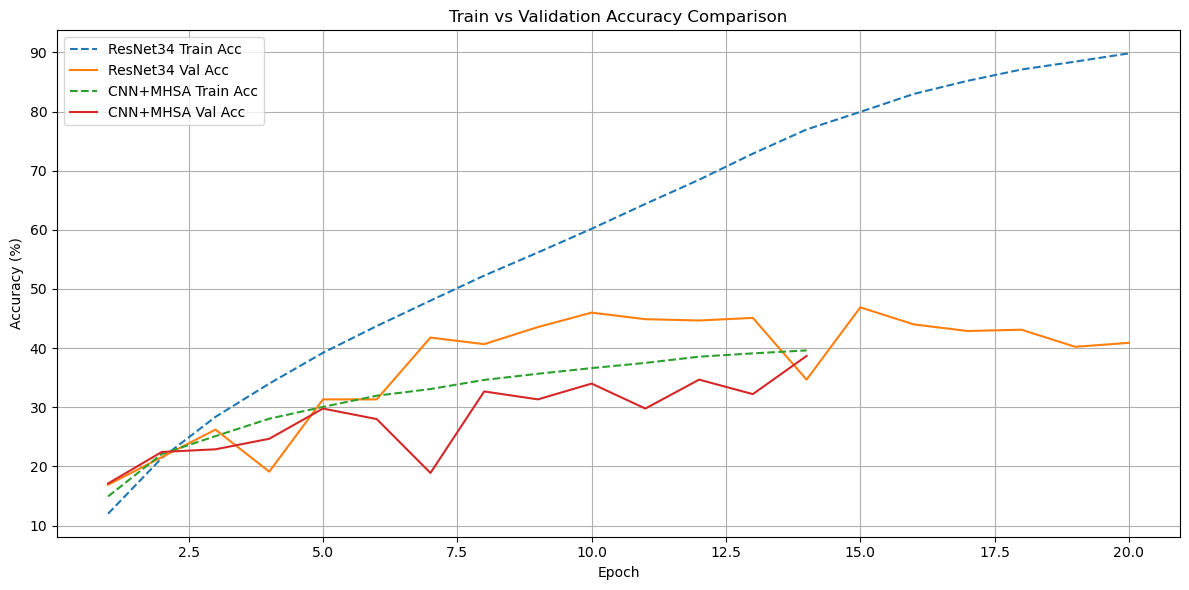

In [4]:
import matplotlib.pyplot as plt

# 模擬你的結果資料
epochs_resnet = list(range(1, 21))
train_acc_resnet = [12.00, 21.42, 28.38, 34.00, 39.21, 43.73, 48.03, 52.26, 56.17, 60.18,
                    64.38, 68.47, 72.88, 76.97, 79.94, 82.99, 85.20, 87.11, 88.44, 89.84]
val_acc_resnet = [16.89, 21.56, 26.22, 19.11, 31.33, 31.33, 41.78, 40.67, 43.56, 46.00,
                  44.89, 44.67, 45.11, 34.67, 46.89, 44.00, 42.89, 43.11, 40.22, 40.89]

epochs_cnnmhsa = list(range(1, 15))
train_acc_cnnmhsa = [14.92, 22.09, 25.12, 28.06, 30.06, 31.95, 33.08, 34.62, 35.66, 36.62,
                     37.50, 38.55, 39.11, 39.61]
val_acc_cnnmhsa = [17.11, 22.44, 22.89, 24.67, 29.78, 28.00, 18.89, 32.67, 31.33, 34.00,
                   29.78, 34.67, 32.22, 38.67]

# 畫圖
plt.figure(figsize=(12, 6))
plt.plot(epochs_resnet, train_acc_resnet, label="ResNet34 Train Acc", linestyle='--')
plt.plot(epochs_resnet, val_acc_resnet, label="ResNet34 Val Acc")
plt.plot(epochs_cnnmhsa, train_acc_cnnmhsa, label="CNN+MHSA Train Acc", linestyle='--')
plt.plot(epochs_cnnmhsa, val_acc_cnnmhsa, label="CNN+MHSA Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
